## Imports / init

In [1]:
# Those two lines are for dev only : they watch imported libraries for changes
#%load_ext autoreload
#%autoreload 2

import brightway2 as bw
import os 

import lca_algebraic as agb

from sympy import init_printing
import bw2io
from dotenv import load_dotenv

# Pretty print for Sympy
init_printing()

# Init brightway2 and databases

In [2]:
# Set the current project
# Can be any name
bw.projects.set_current('MyProject')

# It's better to not leave credential in the code.
# Create a file named .env, that you will not share /commit, and contains the following :
# ECOINVENT_LOGIN=<your_login>
# ECOINVENT_PASSWORD=<your_password>

# This load .env file into os.environ
load_dotenv()

# This downloads ecoinvent and installs biopshere + technosphere + LCIA methods
if len(bw.databases) > 0:
    print("Initial setup already done, skipping")
else:
    # This is now the prefered method to init an Brightway2 with Ecoinvent
    # It is not more tied to a specific version of bw2io
    bw2io.import_ecoinvent_release(
        version="3.9",
        system_model="cutoff",
        username=os.environ["ECOINVENT_LOGIN"], # Read for .env file
        password=os.environ["ECOINVENT_PASSWORD"], # Read from .env file
        use_mp=True)

Initial setup already done, skipping


In [3]:
# We use a separate DB for defining our foreground model / activities
# Choose any name
USER_DB = 'MyForeground'

# This is better to cleanup the whole foreground model each time, and redefine it in the notebook (or a python file)
# instead of relying on a state or previous run.
# Any persistent state is prone to errors.
agb.resetDb(USER_DB)

# Parameters are stored at project level : 
# Reset them also
# You may remove this line if you import a project and parameters from an external source (see loadParam(..))
agb.resetParams()

# Overview of the databases
agb.list_databases()

[WARNING] Db MyForeground was here. Reseting it


,backend,nb_activities,type
name,,,
ecoinvent-3.9-biosphere,sqlite,4709,biosphere
ecoinvent-3.9-cutoff,sqlite,21255,background
MyForeground,sqlite,0,foreground


# Introduction to Numpy

Numpy is a python libray for symbolic calculus. 

You write Sympy expression as you write **standard python expressions**, using **sympy symbols** in them. 

The result is then a **symbolic expression that can be manipulated**, instead of a **numeric value**.

In [4]:
from sympy import symbols 

# create sympy symbol
x = symbols("x")

# Expressions are not directly evaluated 
f = x * 2 + 4 
f

In [5]:
# symbols can be replaced by values afterwards 
f.subs(dict(x=3))

In practice, you don't need to care about Sympy. Just remember that : 
* The parameters defined below are **instances of sympy symbols**
* Any **valid python expression** containing a **sympy symbol** will create a **sympy symbolic expression**

# Define input parameters

First, we define the input parameters of the model together with their distribution.

The numeric parameters are **instances of sympy 'Symbol'**. 

Thus, any python arithmetic expression composed of parameters will result in a **symbolic expression** to be used later in the definition of the model, rather than a static numeric result.

In [6]:
# Example of 'float' parameters
a = agb.newFloatParam(
    'a', 
    default=0.5, min=0.2, max=2,  
    distrib=agb.DistributionType.TRIANGLE, # Distribution type, linear by default
    description="hello world",
    label="extended label for a")

b = agb.newFloatParam(
    'b',
    default=0.5, # Fixed if no min /max provided
    distrib=agb.DistributionType.FIXED,
    description="foo bar")

share_recycled_aluminium = agb.newFloatParam(
    'share_recycled_aluminium',  
    default=0.6, 
    min=0, max=1, std=0.2, 
    distrib=agb.DistributionType.NORMAL, # Normal distrib, with std dev
    description="Share of reycled aluminium")

c = agb.newFloatParam(
    'c',  
    default=0.6, std=0.2, 
    distrib=agb.DistributionType.LOGNORMAL)

beta = agb.newFloatParam(
    'beta',  
    default=0.6, std=0.2, a=2, b=5, 
    distrib=agb.DistributionType.BETA)

# You can define boolean parameters, taking only discrete values 0 or 1
bool_param = agb.newBoolParam(
    'bool_param', 
    default=1)

# Example 'enum' parameter, acting like a switch between several possibilities
# Enum parameters are not Symbol themselves
# They are a facility to represent many boolean parameters at once '<paramName>_<enumValue>' 
# and should be used with the 'newSwitchAct' method 
elec_switch_param = agb.newEnumParam(
    'elec_switch_param', 
    values=["us", "eu"], # If provided as list, all possibilities have te same probability
    default="us", 
    description="Switch on electricty mix")

# Another example enum param
techno_param = agb.newEnumParam(
    'techno_param', 
    values={
        "technoA":0.4, 
        "technoB":0.1,
        "technoC":0.5}, # You can provide a statistical weight for each value, by using a dict
    default="technoA", 
    description="Choice of technology")

## Persistance of parameters

By default, new parameters are kept in memory but also persisted in the project (unless save=False).

You can persist parameters afterwards with `persistParams()`.

You can load also load parameters from an existing database with `loadParams()`.

The persistance of parameters and the distribution is compatible with **Brightway2** and **Activity Browser**  [see documentation of stat_arrays](https://stats-arrays.readthedocs.io/en/latest/)

In [7]:
# Load parameters previously  persisted in the dabatase.
agb.loadParams()

[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param b was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param b was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param c was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param c was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param beta was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param beta was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param bool_param was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] 

# Manage several databases

lca_algebraic supports several foreground / background datasets. Background datasets are considered static / non parametrized by the library : they use standard LCA method of **Brightway2**. 

Foreground databases are considered parametric and their activities are developped as functions of parameters and background activities.

## Set status of a database

The functions **setForeground(...)** and **setBackground(...)** change the status of a database.

In [8]:
agb.setForeground(USER_DB)
agb.list_databases()

,backend,nb_activities,type
name,,,
ecoinvent-3.9-biosphere,sqlite,4709,biosphere
ecoinvent-3.9-cutoff,sqlite,21255,background
MyForeground,sqlite,0,foreground


## Import / export

`lca_algebraic` extends [BW2Package](https://2.docs.brightway.dev/technical/bw2io.html), adding persistence of parameters.

In [9]:
# Save database and parameters as Bzipped JSON
agb.export_db(USER_DB, "tmp/db.bw2")

In [10]:
# Reimport DB
agb.import_db("tmp/db.bw2")

[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] Variable 'a' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param b was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param b was already defined in '<project>' : overriding.
[WARNING] Variable 'b' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
[WARNING] Variable 'share_recycled_aluminium' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param c was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param c was already defined in '<project>' : overriding.
[WARNING] Variable 'c' was already defined : overiddin

Brightway2 SQLiteBackend: MyForeground

## Freeze 

A foreground database can be "frozen" to be used as a background database for a specific scenario : the parametrized amounts in the exhanges are computed for a given configuration of the parameters, and replaced by their value. The formulas are still stored in the database and not lost : the database can still be used as a foreground database until its status is changed with `setBackground(...)`.

This feature is useful for studies requiring several datasets to be used as background by other ones. It also enables to use standard Brightway2 tools, not aware of parametrization. 


In [11]:
agb.freezeParams(
    USER_DB, # Name of database to freeze
    
    a=1, b=2) # custom parameter values

# Get references to background activities

We provide two functions for easy and fast (indexed) search of activities in reference databases : 
* **findBioAct** : Search activity in **biosphere3** db
* **findTechAct** : Search activity in **ecoinvent** db

Those methods are **faster** and **safer** than using traditionnal "list-comprehension" search : 
They will **fail with an error** if **more than one activity** matches, preventing the model to be based on a random selection of one activity.


In [12]:
# Biosphere activities
ground_occupuation = agb.findBioAct('Occupation, industrial area') # Search by name
heat = agb.findBioAct('Heat, waste', categories=['air']) # Add category selector

# Technosphere activities

# You can add an optionnal location selector
alu = agb.findTechAct("aluminium alloy production, AlMg3", loc="RER")
alu_scrap = agb.findTechAct('aluminium scrap, new, Recycled Content cut-off')

# Elec 
eu_elec = agb.findTechAct("market group for electricity, medium voltage", 'ENTSO-E')
us_elec = agb.findTechAct("market group for electricity, medium voltage", 'US')

chromium = agb.findTechAct("market for chromium oxide, flakes")

# Define the model

The model is defined as a nested combination of background activities with amounts.

Amounts are defined either as constant float values or algebric formulas implying the parameters defined above.

## Create new activities

In [13]:
# Create a new activity
activity1 = agb.newActivity(USER_DB, # We define foreground activities in our own DB
    "first foreground activity", # Name of the activity
    "kg", # Unit
    exchanges= { # We define exhanges as a dictionarry of 'activity : amount'
        ground_occupuation:3 * b, # Amount can be a fixed value 
        heat: b + 0.2  # Amount can be a Sympy expression (any arithmetic expression of Parameters)
    })

# You can create a virtual "switch" activity combining several activities with an Enum parameter
elec_mix = agb.newSwitchAct(USER_DB, 
    "elect mix", # Name
    elec_switch_param, # Sith parameter
    { # Dictionnary of enum values / activities
        "us" : us_elec, # By default associated amount is 1
        "eu" : (eu_elec, 0.8)  # You can also provide custom amout or formula with a tuple 
    })

## Copy and update existing activity

You can copy and update an existing background activity.

Several new helper methods have been added to the class **Activity** for easy update of exchanges.

In [14]:
alu2 = agb.copyActivity(
    USER_DB, # The copy of a background activity is done in our own DB, so that we can safely update it                
    alu, # Initial activity : won't be altered
    "Aluminium 2") # New name

# Update exchanges by their name 
alu2.updateExchanges({
    
    # Update amount : the special symbol *old_amount* references the previous amount of this exchange
    "aluminium, cast alloy": agb.old_amount * (1 - share_recycled_aluminium),
    
    # Update input activity. Note also that you can use '*' wildcard in exchange name
    "electricity*": elec_mix,
    
    # Update both input activity and amount. 
    # Note that you can use '#' for specifying the location of exchange (useful for duplicate exchange names)
    "chromium#GLO" : dict(amount=4.0, input=chromium)
}) 

# Add exchanges 
alu2.addExchanges({alu_scrap :  12})

## Final model


In [15]:
total_inventory = agb.newActivity(USER_DB, "total_inventory", "kg", {
    activity1 : b * 5 + a + 1, # Reference the activity we just created
    alu2: 3 * share_recycled_aluminium, 
    alu:0.4 * a})

## Or load existing model /activities from database

Alternatively, you may not define the model again, but load it from the USER DB.

In [16]:
activity1 = agb.findActivity("first foreground activity", db_name=USER_DB)
total_inventory = agb.findActivity("total_inventory", db_name=USER_DB)
alu2 = agb.findActivity("Aluminium 2", db_name=USER_DB)

## Display activities

**printAct** displays the list of all exchanges of an activity.

Note that symbolic expressions have not been evaluated at this stage

In [17]:
# Print_act displays activities as tables
agb.printAct(activity1) 

first foreground activity (1.000000 kg)           \
                                                              input   amount   
Heat, waste                                             Heat, waste  b + 0.2   
Occupation, industrial area             Occupation, industrial area      3*b   

                                                
                                          unit  
Heat, waste                          megajoule  
Occupation, industrial area  square meter-year

In [18]:
agb.printAct(total_inventory)

total_inventory (1.000000 kg)  \
                                                                    input   
Aluminium 2                                          Aluminium 2[RER]{FG}   
aluminium alloy production, AlMg3  aluminium alloy production, AlMg3[RER]   
first foreground activity                   first foreground activity{FG}   

                                                                         
                                                       amount      unit  
Aluminium 2                        3*share_recycled_aluminium  kilogram  
aluminium alloy production, AlMg3                       0.4*a  kilogram  
first foreground activity                         a + 5*b + 1        kg

In [19]:
# You can also compute amounts by replacing parameters with a float value 
agb.printAct(activity1, b=1.5)

first foreground activity (1.000000 kg)  \
                                                              input   
Heat, waste                                             Heat, waste   
Occupation, industrial area             Occupation, industrial area   

                                                                  
                                       amount               unit  
Heat, waste                  1.70000000000000          megajoule  
Occupation, industrial area  4.50000000000000  square meter-year

In [20]:
# You can print several activities at once to compare them
agb.printAct(alu, alu2)

# Select the impacts to consider

In [21]:
# List of impacts to consider
impacts = agb.findMethods("climate change", mainCat="EF v3.0")
impacts

[('EF v3.0', 'climate change', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)'),
 ('EF v3.0',
  'climate change: land use and land use change',
  'global warming potential (GWP100)')]

# Impacts

## Define functional unit

The functional unit is a quantity that can be parametrized


In [22]:
functional_value = a + 5

## Compute impacts

In [23]:
agb.compute_impacts(
    
    # Root activity of our inventory
    total_inventory, 
    
    # list of impacts to consider
    impacts, 
    
    # The impaxts will be divided by the functional unit
    functional_unit=functional_value,
    
    # Parameters of the model
    a=1.0,
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia


,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq]
total_inventory,6.4928,0.0143764,6.47243,0.00598809


In [24]:
# You can compute several LCAs at a time and compare them:
agb.compute_impacts(
    [alu, alu2], # The models
    
    impacts, # Impacts
    
    # Parameters of the model
    share_recycled_aluminium=0.3,
    elec_switch_param="us")

[INFO] Db changed recently, clearing cache expr


,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq]
"aluminium alloy production, AlMg3[RER]",7.30913,0.015893,7.27595,0.0172853
Aluminium 2[RER],30.5944,0.0676333,30.5011,0.0256965


## Fast computation of many parameter values

In [25]:
# Fast computation for millions of separate samples
agb.compute_impacts(
    total_inventory, # The model 
    impacts, # Impacts
    functional_unit = functional_value,
    
    # Parameters of the model
    a=list(range(1, 100000)), # All lists should have the same size
    share_recycled_aluminium=1, # Those parameters are fixed
    elec_switch_param="eu")

,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq]
a,,,,
1,13.6393,0.0323603,13.5979,0.00906581
2,12.1085,0.0286456,12.0711,0.00875842
3,10.9604,0.0258596,10.926,0.00852789
4,10.0674,0.0236926,10.0354,0.00834858
5,9.35303,0.0219591,9.32287,0.00820513
...,...,...,...,...
99995,2.92429,0.00635876,2.91102,0.00691425
99996,2.92429,0.00635876,2.91102,0.00691425
99997,2.92429,0.00635876,2.91102,0.00691425


## Split impacts along axis

It is possible to **tag** activities and then ventilate the impacts according to the value of this "tag".
This is useful to split impact by *phase* or *sub module*.

In [26]:
# Tag activities with a custom attribute : 'phase' in this case
alu2.updateMeta(phase= "phase a")
activity1.updateMeta(phase= "phase b")

In [27]:
# Provide the name of the custom attribute as 'axis'
# The impacts are split between those
agb.compute_impacts(
    total_inventory, # The model
    impacts, # Impacts
    
    functional_unit = functional_value,
    axis="phase",

    
    # Parameters
    a=1.0,
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia


,climate change - global warming potential (GWP100)[kg CO2-Eq],climate change: biogenic - global warming potential (GWP100)[kg CO2-Eq],climate change: fossil - global warming potential (GWP100)[kg CO2-Eq],climate change: land use and land use change - global warming potential (GWP100)[kg CO2-Eq]
phase,,,,
_other_,0.487275,0.00105953,0.485063,0.00115235
phase_a,6.00552,0.0133169,5.98737,0.00483573
phase_b,0,0,0,0
*sum*,6.4928,0.0143764,6.47243,0.00598809


 # Sensitivity analysis 
 
 ## One at a time 
 
 We provide several functions for computing **statistics** for **local variations** of parameters (one at a time).
 
 ### oat_matrix(model, impacts)
 
 Shows a **matrix of impacts x parameters** colored according to the variation of the impact in the bounds of the parameter.


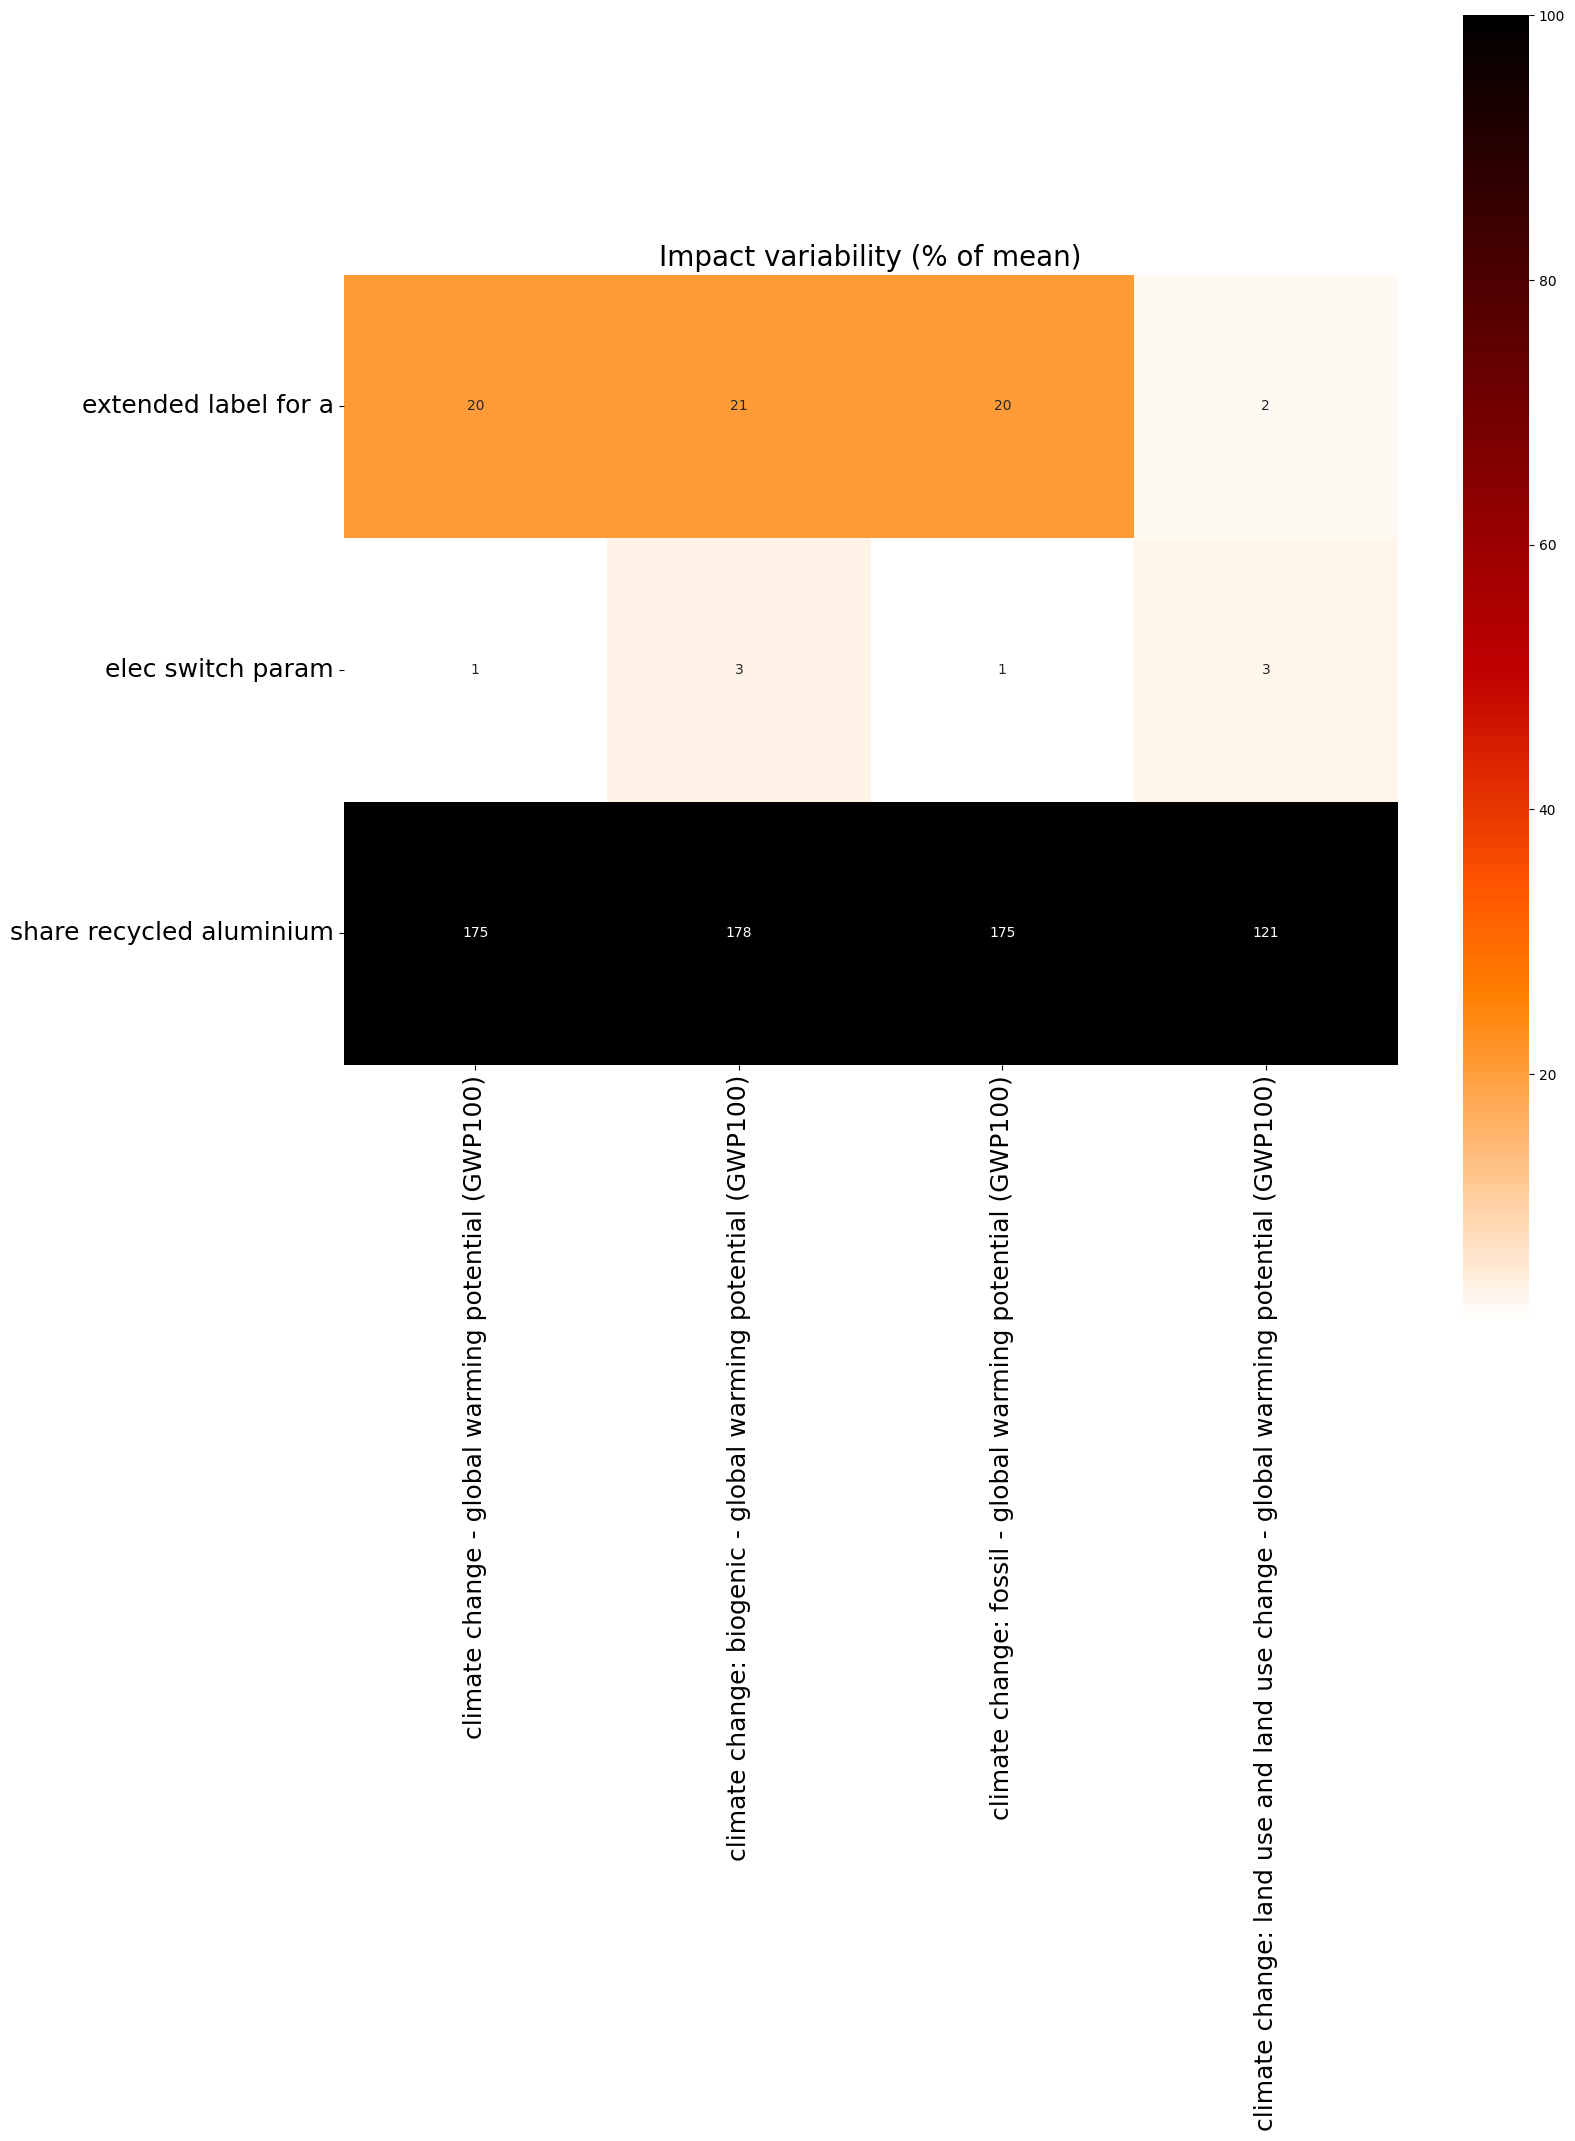

In [28]:
agb.oat_matrix(
    total_inventory, 
    impacts, 
    functional_unit=functional_value)

### oat_dashboard_matrix

This functions draws a dashboard showing :
* A dropdown list, for choosing a parameter
* Several graphs of evolution of impacts for this parameter
* Full table of data
* A graph of "bars" representing the variation of each impact for this parameter (similar to the information given in oat_matrix) 

In [29]:
agb.oat_dashboard(
    total_inventory, 
    impacts, 
    functional_unit=functional_value,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True)

interactive(children=(Dropdown(description='param', options=('elec_switch_param', 'a', 'share_recycled_alumini…

## Monte-carlo methods & Sobol indices

Here we leverage fast computation of monte-carlo approches. 

We compute **global sensivity analysis** (GSA).
Not only local ones.

### Sobol Matrix 

Similar to OAT matrix, we compute Sobol indices. they represent the ratio between the variance due to a given parameter and the total variance.

for easier comparison, we translate those relative sobol indices into "deviation / mean" importance :

$$RelativeDeviation = \frac{\sqrt{sobol(param) \times totalVariance(impact))}}{mean(impact)}$$




In [30]:
# Show sobol indices 
agb.incer_stochastic_matrix(
    total_inventory, 
    impacts, 
    functional_unit=functional_value)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('EF v3.0', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: land use and land use change', 'global warming potential (GWP100)')


/home/rjolivet/lca_algebraic/.tox/py311/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


interactive(children=(Dropdown(description='indice', options=('s1', 'st'), value='s1'), Dropdown(description='…

###  Graphs of impacts and their distribution

We provide a dashboard showing **violin graphs** : the exact probabilistic distribution for each impact. Together with medians of the impacts.

[WARNING] Param 'b' is marked as FIXED, but passed in parameters : ignored


Generating samples ...
Transforming samples ...


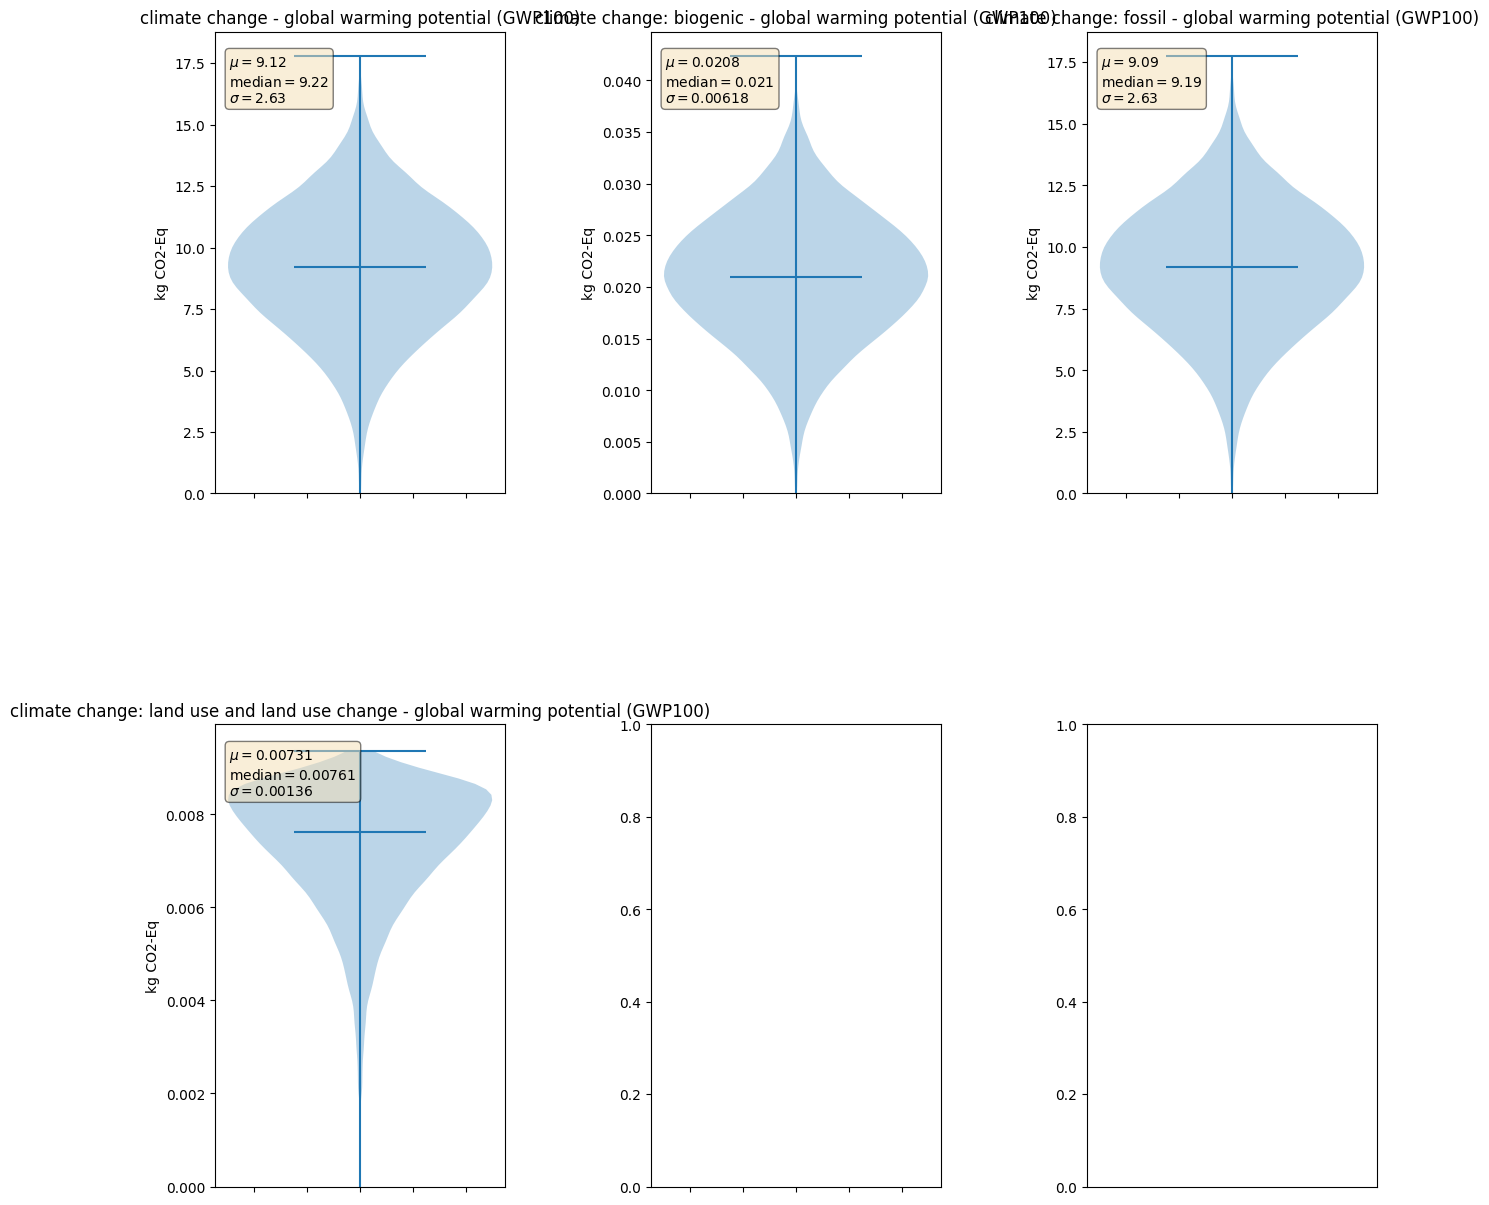

In [31]:
agb.incer_stochastic_violin(
    total_inventory, impacts,
    functional_unit=functional_value,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True, 
    nb_cols=3)

Generating samples ...
Transforming samples ...


[WARNING] Param 'b' is marked as FIXED, but passed in parameters : ignored


,climate change - global warming potential (GWP100) [kg CO2-Eq / ],climate change: biogenic - global warming potential (GWP100) [kg CO2-Eq / ],climate change: fossil - global warming potential (GWP100) [kg CO2-Eq / ],climate change: land use and land use change - global warming potential (GWP100) [kg CO2-Eq / ]
median,9.21098,0.020986,9.18233,0.00761474
std,2.62945,0.00616565,2.62203,0.00134992
p,"[4.655495077080512, 13.302401655380397]","[0.010480454593969825, 0.03072703029999731]","[4.639872398432455, 13.263358094633025]","[0.004697215673802231, 0.008893207315576242]"
mean,9.12345,0.0208455,9.09529,0.00731336
var,0.288208,0.295778,0.288284,0.184583


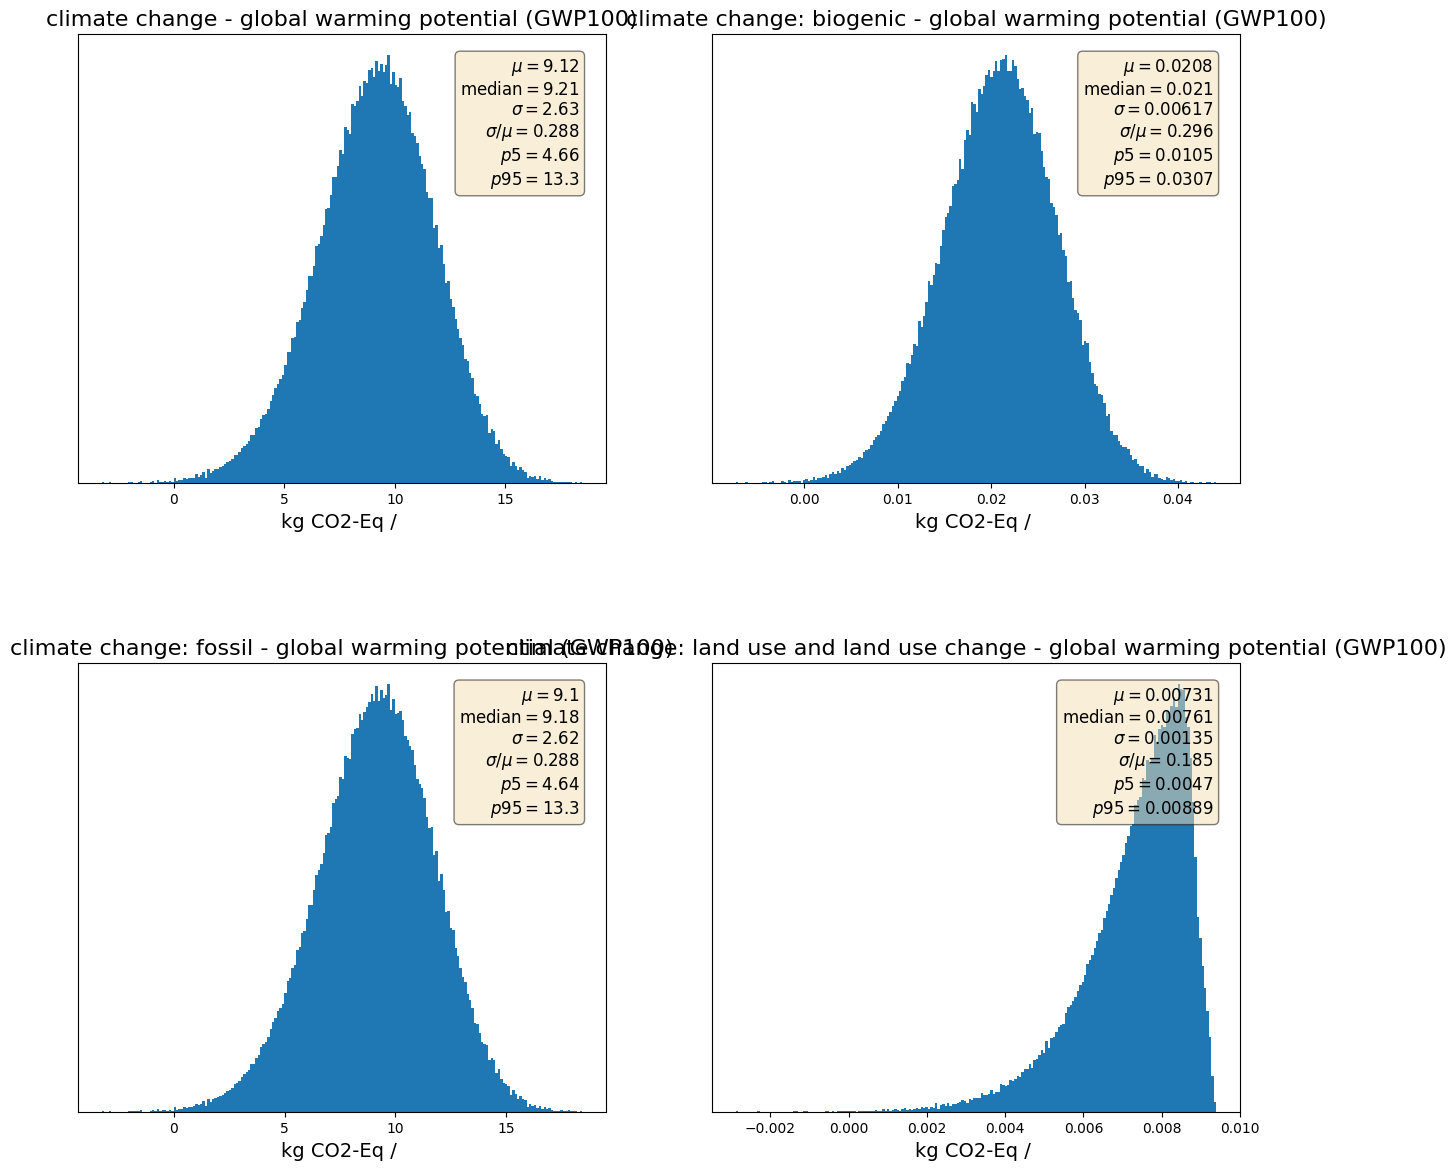

In [32]:
##### Alternatively, graphs can be shown horizontally, together with a box of statistical outcomes
agb.distrib(
    total_inventory, impacts,
    functional_unit=functional_value,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2,
    percentiles=[5, 95])

### Full dashboard

A dashboard groups all this information in a single interface with tabs.

It also shows total variation of impacts. This last graph could be improved by showing stacked colored bars with the contribution of each parameter to this variation, according to Sobol indices. 

In [33]:
agb.incer_stochastic_dashboard(
    model=total_inventory, 
    methods=impacts,
    functional_unit=functional_value)

[WARNING] Param 'b' is marked as FIXED, but passed in parameters : ignored


Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('EF v3.0', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)')


/home/rjolivet/lca_algebraic/.tox/py311/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Processing sobol for ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: land use and land use change', 'global warming potential (GWP100)')


# Producing simplified models 

One of te outcome of the statisticall analysis above would be to identify main input parameters and produce simplidied models, fixing the minor ones.

We provide several functions for doing this.

## Explore initial algrebraic model

In [34]:
# First, let's look at the full expression defining our model
expr, _ = agb._actToExpression(total_inventory)
expr

## Compute simplified models

We provide some method to automatically select a subset of parameters, based on the **sobol indices**, and then compute simplified models for it.

We also round numerical expression to 3 digits, and we remove terms in sums that are less than 1% of total.

In [36]:
simplified = agb.sobol_simplify_model(
    total_inventory, # The model
    impacts, # Impacts to consider
    functional_unit=functional_value,
    
    n=1000, # For large model, you may test other value and ensure ST and sum(S1) are close to 1.0 
    fixed_mode = agb.FixedParamMode.MEDIAN, # We replace minor parameters by median by default,
    min_ratio=0.8, # Min ratio of variability to explain
    num_digits=3)

/home/rjolivet/lca_algebraic/.tox/py311/lib/python3.11/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[WARNING] Param 'b' is marked as FIXED, but passed in parameters : ignored


Generating samples ...
Transforming samples ...
Processing sobol for ('EF v3.0', 'climate change', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)')


/home/rjolivet/lca_algebraic/.tox/py311/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Processing sobol for ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)')
Processing sobol for ('EF v3.0', 'climate change: land use and land use change', 'global warming potential (GWP100)')
> Method :  climate change - global warming potential (GWP100)
S1:  0.9930526859439568
S2:  0.051434250646092555
ST:  1.0062348752524026
Selected params :  ['share_recycled_aluminium'] explains:  0.9683778519635373


> Method :  climate change: biogenic - global warming potential (GWP100)
S1:  0.9937696441331528
S2:  0.0382551727844193
ST:  1.0068989491538092
Selected params :  ['share_recycled_aluminium'] explains:  0.9668512669476762


> Method :  climate change: fossil - global warming potential (GWP100)
S1:  0.9930493545236683
S2:  0.05147801968954844
ST:  1.0062360583470846
Selected params :  ['share_recycled_aluminium'] explains:  0.968343555520936


> Method :  climate change: land use and land use change - global warming potential (GWP100)
S1:  0.9901255684648551
S2:  0.06999477531502071
ST:  1.006650555242752
Selected params :  ['share_recycled_aluminium'] explains:  0.9836306171832606


In [37]:
# Let's look at the expression for first impact again 
# much simpler ! 
simplified[0].expr

## Compare simplified model with full model

Finally, we can compare the distribution of those simplified model against the full model. We provide a function for graphical display of it, and compuation of de R-Square score.


In [ ]:
agb.compare_simplified(
    total_inventory, 
    impacts, 
    simplified,
    functional_unit=functional_value)

Generating samples ...
Transforming samples ...


[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'a' was missing, replacing by default value : 0.5
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
/home/rjolivet/lca_algebraic/.tox/py311/lib/python3.11/site-packages/lca_algebraic/stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


Generating samples ...
Transforming samples ...


[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'a' was missing, replacing by default value : 0.5
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
/home/rjolivet/lca_algebraic/.tox/py311/lib/python3.11/site-packages/lca_algebraic/stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


Generating samples ...
Transforming samples ...


[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'a' was missing, replacing by default value : 0.5
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
/home/rjolivet/lca_algebraic/.tox/py311/lib/python3.11/site-packages/lca_algebraic/stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


Generating samples ...
Transforming samples ...


[INFO] Required param 'elec_switch_param' was missing, replacing by default value : us
[INFO] Required param 'a' was missing, replacing by default value : 0.5
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
[INFO] Required param 'share_recycled_aluminium' was missing, replacing by default value : 0.6
/home/rjolivet/lca_algebraic/.tox/py311/lib/python3.11/site-packages/lca_algebraic/stats.py:1349: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,
